# Adaptive Mesh Refinement and Surface Tension

Here, we introduce, develop, and test force functionals for surface tension, and methods for adjusting local mesh resolution along the boundary. We start in 2D, and will eventually try to generalize to 3D.

## Surface Tension in 2D
Let the surface energy of a body be proportional to its surface area; or in 2D, the total length of the boundary:

$E[\{ \vec{X}_i\} ] = \gamma \sum_{i=0}^N ||\vec{X_i} - \vec{X}_{i-1}||$

where $\gamma$ is surface energy per unit length, and we let $\vec{X}_{-1} \equiv \vec{X}_N$ to express the energy functional in a more concise and pythonic manner. Then, 



$\vec{F}_j = \frac{\delta E[ \{ \vec{X}_i\} ]}{\delta \vec{X}_j} = \gamma \Bigg[ \frac{\partial ||\vec{X}_j - \vec{X}_{j-1}||}{\partial \vec{X}_j} + \frac{\partial ||\vec{X}_{j+1} - \vec{X}_j||}{\partial \vec{X}_j }\Bigg] $


$= \gamma \Bigg[ \frac{\vec{X}_j - \vec{X}_{j-1}}{||\vec{X}_j - \vec{X}_{j-1}||} -\frac{\vec{X}_{j+1} - \vec{X}_j}{||\vec{X}_{j+1} - \vec{X}_j|| }\Bigg]$

which is the difference of two unit vectors, and always points tangential to the surface. Let's start by subclassing IB2 with this Force, and adding a few methods to be explained later:

In [1]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from ib2 import IB2         #### 2D Immersed Boundary object (droplet membrane)
# from ib2_amr import IB2 as IB2_AMR         #### 2D Immersed Boundary object (droplet membrane)
from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')

from IPython.display import display


class IB2_AMR(IB2):
    
    def __init__(self, X, N, h, dt, a=1.0, **kwargs):
        super(IB2_AMR, self).__init__(X, N, h, dt, **kwargs)
        self.Force = self.Force_surf
        
    def Force_surf(self, X):
        K, kp, km = self.K, self.kp, self.km
        dX = X - X[km]
        lX = np.linalg.norm(dX, axis=1)
        return self.K*(dX[kp]/lX[kp, np.newaxis] - dX/lX[:, np.newaxis])/(self.dtheta)
    
    def split_X(self, indices):
        indices.sort(reverse=True)
        X = [x for x in self.X]  ## It's ~10x faster to convert to list and use python insert than to use numpy insert
        for i in indices:    X.insert(i, 0.5*(X[i] + X[i-1]))
        self.X = np.vstack(X)
        self.Nb = self.Nb + len(indices)
        
    def merge_X(self, indices):
        indices.sort(reverse=True)
        X = [x for x in self.X]  ## It's ~10x faster to convert to list and use python insert than to use numpy insert
        i_prev = -2
        for i in indices:
            if i_prev == i+1: continue ## Don't resolve adjacent segments in the same timestep
            X[i-1] = 0.5*(X[i] + X[i-1])
            del X[i]
            i_prev = i
        self.X = np.vstack(X)
        self.Nb = len(self.X)
        
    def adj_X(self, split, merge):
        self.split_X(split)
#         split.sort(reverse=True) # unnecessary because split_X sorts indices
        merge = np.array(merge)
        for i in split: merge[merge>i] +=1
        merge = list(merge)
        self.merge_X(merge)
        
    def step_XX(self, u): 
        lX = np.linalg.norm(self.X - self.X[self.km], axis=1)
        ii = self.km+1
        self.adj_X(list(ii[lX>0.3*self.h]), list(ii[lX<0.1*self.h]))
        super(IB2_AMR, self).step_XX(u)
   
#     @property
#     def dtheta(self): return 1.



$dX_k / dt = (U_k \cdot N_k) N_k + a ((X_{k+1} - 2 X_k + X_{k-1}) \cdot T_k) T_k$


# Circular Membrane in Stationary Fluid

To test our force functional, let's take a simple case and look at the surface tension forces. We also ought to  check that the total force exerted on the fluid converges as the number of boundary points is increased.  

<IPython.core.display.Javascript object>


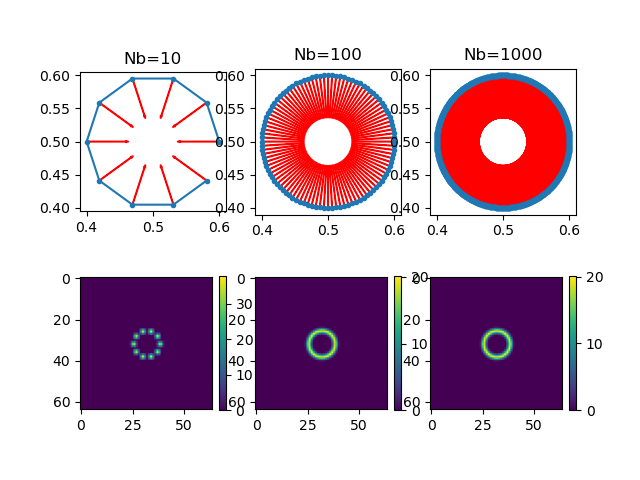

Maximum Force Density: 0.05901789858500807
Total Force on Fluid: 1518.8732517815224

Maximum Force Density: 0.059990130882658345
Total Force on Fluid: 1533.9785068294002

Maximum Force Density: 0.059999901307211743
Total Force on Fluid: 1534.2283209011057



In [7]:
def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

fluid = FLUID()
fig = plt.figure()

rad=.1
Nb_vals = [10, 100, 1000]
NNb = len(Nb_vals)

def plot_force(s, ax, ax2=None):
    ax.plot(s.X[:,0], s.X[:,1], marker='.')
    ax.set_aspect('equal', 'box')
    F = s.Force(s.X)*.06
    print('Maximum Force Density: {}'.format(np.max(np.linalg.norm(F, axis=1))))
    for i, x in enumerate(s.X): ax.arrow(x[0], x[1], F[i][0], F[i][1], color='red', linewidth=1)
    f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
    # f*=(Nb*fluid.h)**(-1)
    c = ax2.imshow(f)
    plt.colorbar(c, ax=ax2, fraction=0.046)
    print('Total Force on Fluid: {}'.format(np.sum(f)))
    print()
    return f
    
for ii, Nb in enumerate(Nb_vals):
#     s = IB2( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt, K=10) 
    s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
    
#     ax = fig.add_subplot(NNb, 2, 2*ii+1)
#     ax2 = fig.add_subplot(NNb, 2, 2*ii+2)
    ax = fig.add_subplot(2, NNb, ii+1)
    ax.set_title('Nb={}'.format(Nb))
    ax2 = fig.add_subplot(2, NNb, ii+4)
    
    f = plot_force(s, ax, ax2)
    
f_unif = f.copy()

Note that the force exerted on the fluid becomes "disjoint" when there are only a few boundary points, but "smooths" out when the spacing between points becomes comparable to the grid spacing. Also note from the colorbar that the the total force exerted on the fluid approaches a finite value as the number of boundary points increases. 

### Force vs Force Density
We note that the quantity $\vec{F}$, illustrated by red arrows, is force density rather than force. This convention is useful because as the number of boundary points $N_b \xrightarrow{} \infty$, the *force* on each point $\vec{F} \xrightarrow{} 0$, whereas the force per unit measure $d\theta\equiv 2\pi/N_b$ remains finite.  

As described in a paper by Wu, Peskin et al on osmotic swelling (https://www.researchgate.net/publication/281719583_Simulation_of_Osmotic_Swelling_by_the_Stochastic_Immersed_Boundary_Method/link/5ce847faa6fdccc9ddccce58/download), we may also use the convention where $\vec{F}$ is the force itself by adjusting the factor of $d\theta$. In the force-density convention shown above, we have $\vec{F} \propto 1/d\theta$ to keep $\vec{F}$ finite, and see that in this case a factor of $d\theta$ in the spreading operator keeps the total force $\vec{f}$ on the fluid finite. If we instead want $\vec{F}$ to be the *Force*, we would remove the factor of $1/d\theta$ from $\vec{F}$, and would then need to also remove a factor of $d\theta$ from the spreading operator in order to keep the force on the fluid finite. In this particular case, this would be equivalent to setting $d\theta=1$. One can easily confirm that doing so above results in $\vec{F} \xrightarrow{} 0$ as $N_b \xrightarrow{} \infty$, while the total force on the fluid still remains finite. 



We may also plot the maximum/total force as a function of various $N_b$, $r$:

<IPython.core.display.Javascript object>


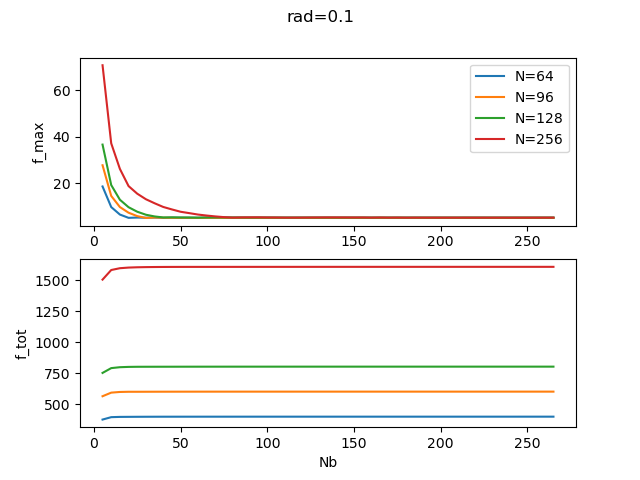

<IPython.core.display.Javascript object>


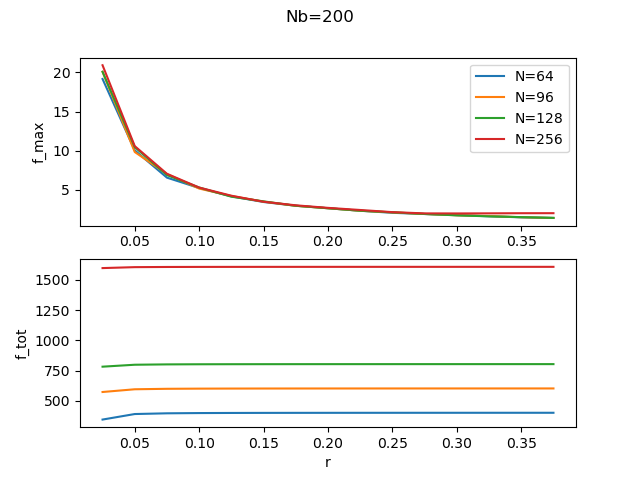

Text(0.5, 0.98, 'Nb=200')

In [8]:
# def FORCE_CONVERGENCE_TEST(FLUID, SOLID):
#     Nb_vals = np.arange(5, 270, 5)
#     rad=0.1

#     fig = plt.figure()
#     ax1 = plt.subplot(2,1,1)
#     ax1.set_ylabel('f_max')
#     ax2 = plt.subplot(2,1,2)
#     ax2.set_xlabel('Nb')
#     # ax2.set_xlabel('r dtheta / h')
#     ax2.set_ylabel('f_tot')

#     for N in [64, 96, 128, 256]:
#         fluid = FLUID(N=N)
#         f_max = []
#         f_tot = []
#         for Nb in Nb_vals:

#             s = SOLID( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
#             F = s.Force(s.X)*fluid.h
#             f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
#             f_max.append(np.max(f))
#             f_tot.append(np.sum(f))

#         ax1.plot(Nb_vals, f_max, label='N={}'.format(N))
#         ax2.plot(Nb_vals, f_tot)
#     #     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     #     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
#         # fig.suptitle('rad={}, N={}'.format(rad, N))
#     ax1.legend()
#     fig.suptitle('rad={}'.format(rad))



#     rad_vals = np.arange(0.025, 0.4, 0.025)
#     Nb=200

#     fig = plt.figure()
#     ax1 = plt.subplot(2,1,1)
#     ax1.set_ylabel('f_max')
#     ax2 = plt.subplot(2,1,2)
#     # ax2.set_xlabel('Nb')
#     ax2.set_xlabel('r')
#     # ax2.set_xlabel('r dtheta / h')
#     ax2.set_ylabel('f_tot')

#     for N in [64, 96, 128, 256]:
#         fluid = FLUID(N=N)
#         f_max = []
#         f_tot = []
#         for rad in rad_vals:

#             s = SOLID( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
#             F = s.Force(s.X)*fluid.h
#             f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
#             f_max.append(np.max(f))
#             f_tot.append(np.sum(f))

#         ax1.plot(rad_vals, f_max, label='N={}'.format(N))
#         ax2.plot(rad_vals, f_tot)
#     #     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     #     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
#         # fig.suptitle('rad={}, N={}'.format(rad, N))
#     ax1.legend()
#     fig.suptitle('Nb={}'.format(Nb))

# FORCE_CONVERGENCE_TEST(FLUID, IB2_AC)





Nb_vals = np.arange(5, 270, 5)
rad=0.1

fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel('f_max')
ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Nb')
# ax2.set_xlabel('r dtheta / h')
ax2.set_ylabel('f_tot')

for N in [64, 96, 128, 256]:
    fluid = FLUID(N=N)
    f_max = []
    f_tot = []
    for Nb in Nb_vals:
        
        s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
        F = s.Force(s.X)*fluid.
        f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
        f_max.append(np.max(f))
        f_tot.append(np.sum(f))

    ax1.plot(Nb_vals, f_max, label='N={}'.format(N))
    ax2.plot(Nb_vals, f_tot)
#     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
    # fig.suptitle('rad={}, N={}'.format(rad, N))
ax1.legend()
fig.suptitle('rad={}'.format(rad))



rad_vals = np.arange(0.025, 0.4, 0.025)
Nb=200

fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel('f_max')
ax2 = plt.subplot(2,1,2)
# ax2.set_xlabel('Nb')
ax2.set_xlabel('r')
# ax2.set_xlabel('r dtheta / h')
ax2.set_ylabel('f_tot')

for N in [64, 96, 128, 256]:
    fluid = FLUID(N=N)
    f_max = []
    f_tot = []
    for rad in rad_vals:
        
        s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
        F = s.Force(s.X)*fluid.h
        f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
        f_max.append(np.max(f))
        f_tot.append(np.sum(f))

    ax1.plot(rad_vals, f_max, label='N={}'.format(N))
    ax2.plot(rad_vals, f_tot)
#     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
    # fig.suptitle('rad={}, N={}'.format(rad, N))
ax1.legend()
fig.suptitle('Nb={}'.format(Nb))




## Non-Circular Boundaries and Curvature

What do forces look like on a non-circular boundary? We can try and find out by modulating the radius of the circle; i.e. looking at the curve

$ R(\theta) = R_0(1+A\sin{n\theta})$

Note that for non-integer $n$, $R(0) \neq R(2\pi)$ and $R(\theta)$ is not periodic. Some examples and the corresponding forces are shown below:

<IPython.core.display.Javascript object>


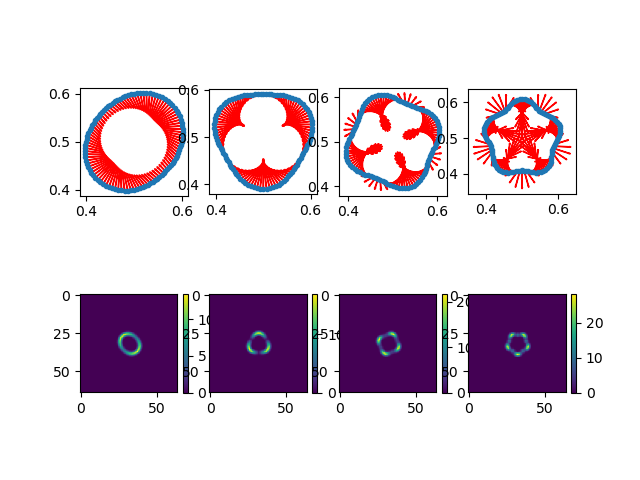

Maximum Force Density: 0.04492647191938381
Total Force on Fluid: 795.7663414939332

Maximum Force Density: 0.05985617492132849
Total Force on Fluid: 834.4351544630774

Maximum Force Density: 0.08055662759810595
Total Force on Fluid: 1004.583422282497

Maximum Force Density: 0.10722753821985823
Total Force on Fluid: 1286.27119959115



In [15]:
fluid = FLUID()
def MOD_CIRCLE(RAD=1., POS=(0.,0.), Nb=100, modA=0.1, n=4):
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    RAD += RAD*modA*np.sin(theta*n)
    return RAD[:, np.newaxis]*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

f_vals = [2, 3, 4, 5]
Nf = len(f_vals)
fig = plt.figure()
for ii, f in enumerate(f_vals):
#     s = IB2_AMR( MOD_CIRCLE(0.1, [0.5,0.5], 100, modF=f), fluid.N, fluid.h, fluid.dt) 
    s = IB2( MOD_CIRCLE(0.1, [0.5,0.5], 100, n=f), fluid.N, fluid.h, fluid.dt, K=5) 
    
    ax = fig.add_subplot(2,Nf,ii+1)
    ax2 = fig.add_subplot(2, Nf, ii+5)
    ax.set_aspect('equal', 'box')
    ax2.set_aspect('equal', 'box')
    plot_force(s, ax, ax2)
    

<IPython.core.display.Javascript object>


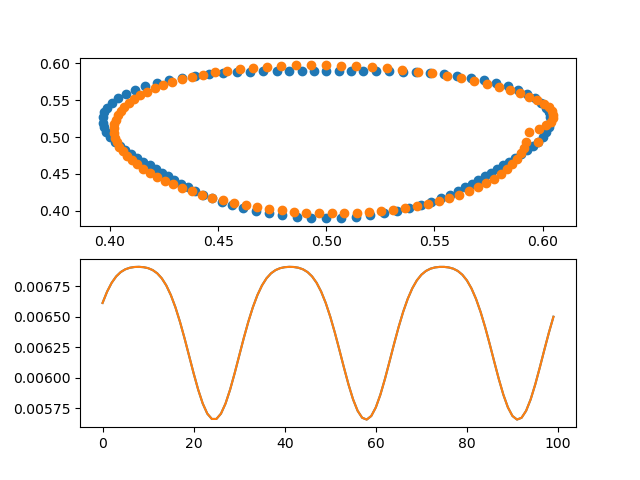

In [19]:
from scipy.interpolate import splprep, splev

    
def interpolate(traj):
    '''
    Smooth out trajectories with scipy interpolation.
    '''
    L = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1)) 
    Nb = len(traj)
    trajs = []
   
    target = traj[-1]
    tspace = np.linspace(0, 1, Nb)
    x = traj[:, 0]
    y = traj[:, 1]
     
    tck, u = splprep([x, y], s=Nb, k=5)
    xnew, ynew = splev(tspace, tck)
    traj = np.asarray([[xnew[j], ynew[j]] for j in range(Nb)])
    traj[-1] = target
    return traj


Xi = MOD_CIRCLE(0.1, [0.5,0.5], 100, n=3)
Xf = interpolate(Xi)
fig = plt.figure()
axes = [fig.add_subplot(2,1,i+1) for i in range(2)]
for X in [Xi, Xf]:
    axes[0].scatter(*[X[:, i] for i in range(2)])
    D = X - np.roll(X, -1, axis=0)   
    L = np.linalg.norm(D, axis=1)
    axes[1].plot(Li)
    

These examples clearly show that surface tension is higher in regions with large curvature. 

# Boundary Spacing and Mesh Refinement

The diagrams above give us a good idea of the surface tension forces, and we have established that the total surface tension force but we have not yet fully accounted for the affects of boundary spacing. While we have shown that but there is a small caveat which we have not yet considered. We have already seen that the spacing of boundary points may affect the corresponding surface tension force of those points.



To more clearly see this affect at play, let's take a look a circle with non-uniformly spaced boundary points. For comparison, let's also plot two uniformly spaced circles corresponding to the largest and smallest spacings of the first: 

<IPython.core.display.Javascript object>


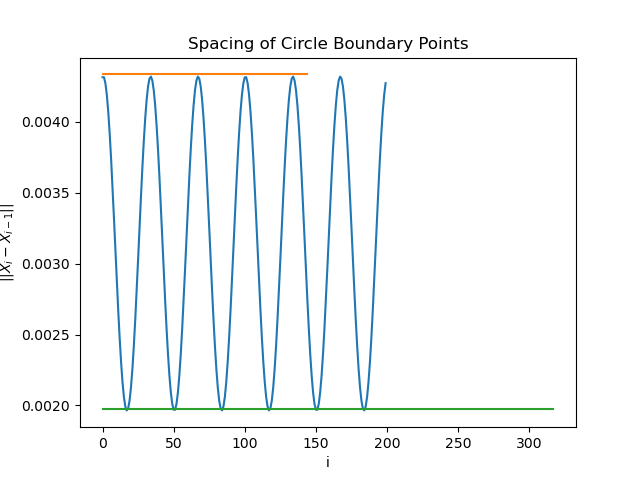

<IPython.core.display.Javascript object>


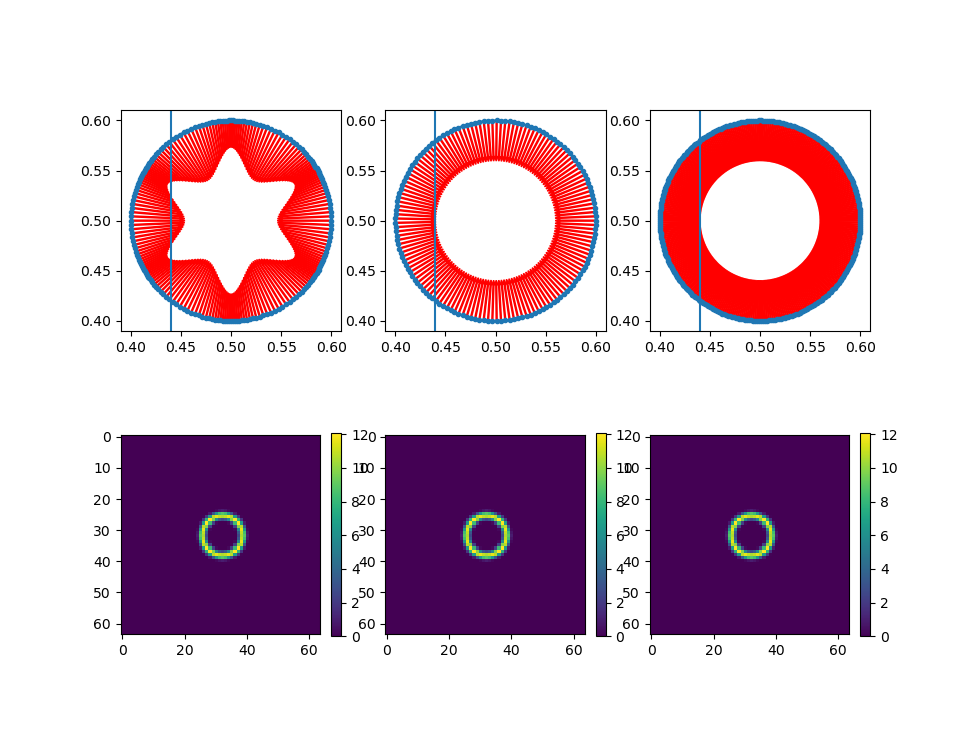

Maximum Force Density: 0.049420502129016476
Total Force on Fluid: 920.4926735287688

Maximum Force Density: 0.03599718353217843
Total Force on Fluid: 920.4664988261643

Maximum Force Density: 0.035999414408830775
Total Force on Fluid: 920.5235426557796



In [10]:
def NONUNIF_CIRCLE(RAD=1., POS=(0.,0.), Nb=100, modF=6):
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    theta += 4*np.pi*np.sin(theta*modF)/(Nb+1)
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS



Nb=200
X1 = NONUNIF_CIRCLE(0.1, [0.5,0.5], Nb)
dNorm = lambda X: np.linalg.norm(X - X[np.arange(len(X))-1], axis=1)
dX1 = dNorm(X1)
X2 = CIRCLE(.1, [.5, .5], 145)#int(rad/(2*np.pi*min(dX1))))
X3 = CIRCLE(.1, [.5, .5], 318)##int(rad/(2*np.pi*max(dX1))))
plt.figure()
plt.plot(dX1)
plt.xlabel('i')
plt.ylabel('$||X_i - X_{i-1}||$')
plt.title('Spacing of Circle Boundary Points')
for X in X2, X3: plt.plot(dNorm(X))

    
    
XX = [X1, X2, X3]
ss = [IB2_AMR(X, fluid.N, fluid.h, fluid.dt, K=.6) for X in XX]
fig = plt.figure()
f_non=[]
for i, s in enumerate(ss):
    ax = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    f_non.append(plot_force(s, ax, ax2))
    ax.axvline(x=0.44)
# s = IB2_AMR( X3, fluid.N, fluid.h, fluid.dt) 
# # s = IB2( MOD_CIRCLE(0.1, [0.5,0.5], 100, modA=modA, modF=f), fluid.N, fluid.h, fluid.dt, K=10) 
# ax = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# f_non = plot_force(s, ax, ax2).copy()

Now, we see that the total force on the fluid is the same, but the force density varies *spacially* - the force density is larger in regions of larger spacing, and vice versa. We can see this clearly by looking at the difference between the force on the fluid in each case:

<IPython.core.display.Javascript object>


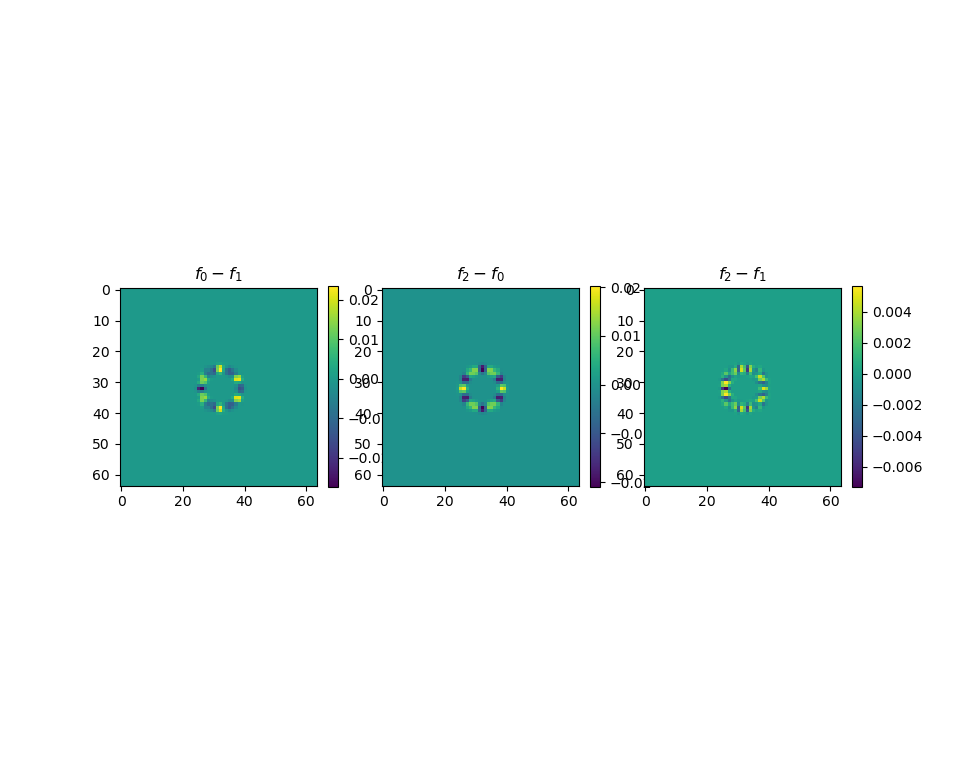

Total (abs) Difference in Force:
Total (abs) Difference in Force:
Total (abs) Difference in Force:


In [9]:
fig = plt.figure()
cases = [[0,1], [2,0], [2,1]]
DF = [f_non[i]-f_non[j] for i, j in cases]
for i, df in enumerate(DF):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title('$f_{} - f_{}$'.format(cases[i][0], cases[i][1]))
    c = ax.imshow(df)
    plt.colorbar(c, ax=ax, fraction=.046)
    print('Total (abs) Difference in Force:')
# # df = f_unif - f_non
# df = f_non[0] - f_non[1]
# print(np.shape(df))
# c = plt.imshow(df)
# plt.colorbar(c)

# Shrinking vs Time

In the absence of external forces, we might expect surface tension to cause the boundary to shrink to a point where surface tension forces are balanced by the droplets internal pressure (more specifically, the incompressibility of the fluid inside the droplet). 

- R(t)
Total Force (  (t)   )
vs   K


- How do forces scale vs springs?
- Is there an eq size?
- Does size depend on boundary spacing etc? How even does spacing need to be?

In [41]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 500          # simulation time 
nmod = 10               # save every nmod frames

# Immersed Body Parameters
K = 1.0
Nb = 100
rad=.25
pos=[0.5, 0.5]




#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX)                     # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)

def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS


In [ ]:
#### Shrinking vs Nb
vals = [50, 100, 150, 200, 250]; var='Nb'  
# vals = [.5, 1., 2., 5., 7.5]; var='K'  

X = [[] for v in vals]
f = [[] for v in vals]

dh1 = display('--', display_id=True)
dh2 = display('--', display_id=True)
for ii, val in enumerate(vals):
    Nb=val  
#     K=val
    dh1.update('{}={}'.format(var, val))
    fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
#     solids=[IB2(CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=K)]
    solids=[IB2_AMR(CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=K)]
    
    for i in np.arange(nsteps):
        dh2.update('{}/{}'.format(i, nsteps))
        iterate(fluid, solids)
#         if i%nmod!=0: continue
        X[ii].append(solids[0].X.copy())
        f[ii].append(np.linalg.norm(solids[0].vec_spread(solids[0].Force(solids[0].X), solids[0].X), axis=0))
        

'Nb=50'

'111/500'

<IPython.core.display.Javascript object>


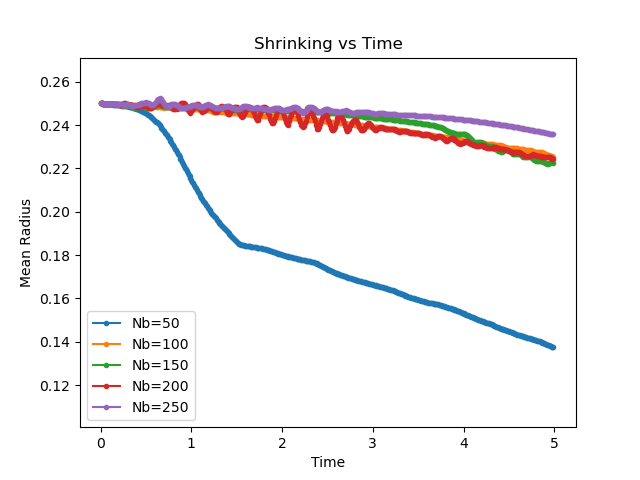

In [25]:
X0 = [ [x - np.mean(x, axis=0)[np.newaxis,:] for x in iX] for iX in X]

# plt.figure()
# for x in X0[1]: plt.scatter(*[x[:,i] for i in range(2)])
RR = [ [np.linalg.norm(x, axis=1) for x in iX] for iX in X0]

# print(np.shape(RR))
RR0 = [np.mean(r, axis=1) for r in RR]
# print(np.shape(RR0))
plt.figure()
for i, rr0 in enumerate(RR0): plt.plot(dt*np.arange(0, nsteps), rr0, marker='.', label='{}={}'.format(var, vals[i]))
# for rr0 in RR0: plt.plot(dt*np.arange(0, nsteps, nmod), rr0, marker='.')
plt.title('Shrinking vs Time')
plt.xlabel('Time' )
plt.ylabel('Mean Radius')
plt.ylim([0, 1])
plt.legend()
# plt.figure()
# for frc in f: 
#     print(np.shape(f))
#     plt.plot(np.sum(np.sum(frc, axis=-1), axis=-1))

<IPython.core.display.Javascript object>


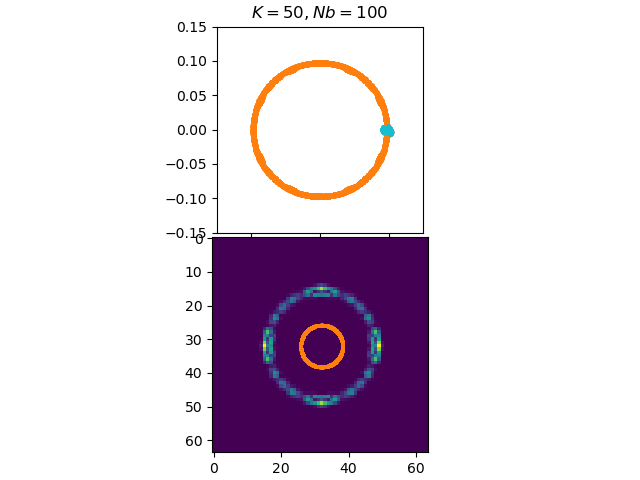

90

In [40]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)

# axes = [fig.add_subplot(1, nfigs, i+1) for i in range(nfigs)]
axes = [fig.add_subplot(2, nfigs, i+1) for i in range(nfigs)]
axes_0 = [fig.add_subplot(2, nfigs, i+1+nfigs) for i in range(nfigs)]
for j, axj in enumerate(axes):
#     axj.set_title('$K={}, Nb={}$'.format(K, vals[j]))
    axj.set_title('$K={}, Nb={}$'.format(vals[j], Nb))
    axj.set_aspect('equal', 'box')
    axj.set_xlim([-1.5*rad, 1.5*rad]); axj.set_ylim([-1.5*rad, 1.5*rad])


# for ax in axes_0: ax.set_xlim([0, 1.]); ax.set_ylim([0, 1.]);
cmap = plt.get_cmap('tab10')
ims = []
dh = display('', display_id=True)
for i in range(len(X[0])):
    if i%10==0: dh.update(i)
    im=[]
    for j, axj in enumerate(axes):
        x = X[j][i]
        ax0 = axes_0[j]
        im.append(ax0.imshow(f[j][i].transpose()))
        im.append(ax0.scatter(x[:,0]*fluid.N, x[:,1]*fluid.N, color=cmap(1),s=1))
        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1), s=1))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color=cmap(i)))  ## Mark theta=0
#         im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        

In [27]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('thing.gif', writer='pillow')

In [28]:
# ani2.save('shrinking_and_forces.gif', writer='pillow')

In [ ]:
def get_theta(X): return np.arctan2(X[:,:,1], X[:,:,0])
def get_radii(X): return np.linalg.norm(X, axis=2)


In [10]:
a = list(range(10))
a=np.array(a)
a[a>=5]+=1
a=list(a)
print(a)

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]


# Boundary Resolution and Local Refinement

We showed above that points which are spaced too far apart may give a partially-unresolved force on the fluid. Consequently, we need a technique for adding or subtracting boundary points. The simplest method is to simply add a vertex at the midpoint whenever an edge becomes too long, and to remove a vertex when an edge is too short. 

Note that adding vertices in this manner does not increase the total length of the boundary, and consequently does not change the energy of the boundary. Likewise, removing boundary points change the length of the boundary by at most ~ the length of the edge being removed - which is very small by definition.

In [105]:
def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

fluid = FLUID()
s = IB2_AMR(CIRCLE(.1, (.5, .5), Nb=10), fluid.N, fluid.L, fluid.dt)

<IPython.core.display.Javascript object>


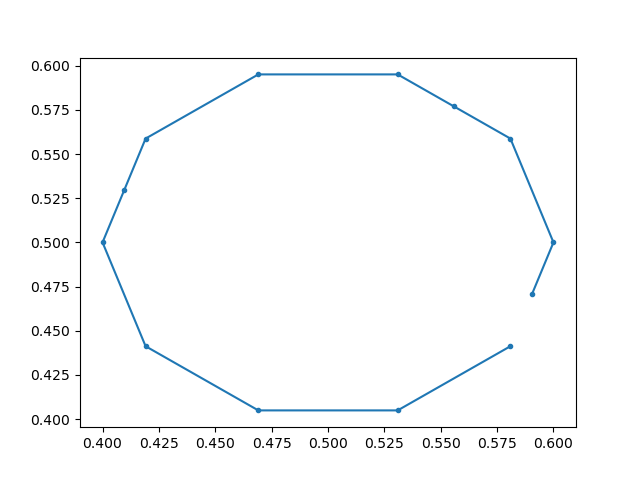

13


<IPython.core.display.Javascript object>


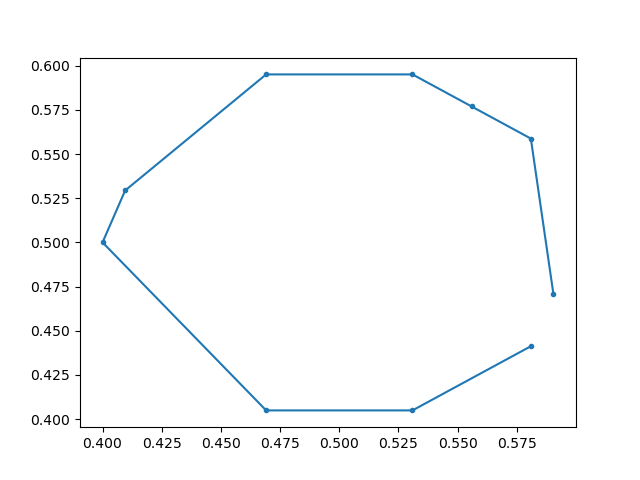

10
[[0.59045085 0.47061074]
 [0.5809017  0.55877853]
 [0.5559017  0.57694209]
 [0.5309017  0.59510565]
 [0.4690983  0.59510565]
 [0.40954915 0.52938926]
 [0.4        0.5       ]
 [0.4690983  0.40489435]
 [0.5309017  0.40489435]
 [0.5809017  0.44122147]]
10


<IPython.core.display.Javascript object>


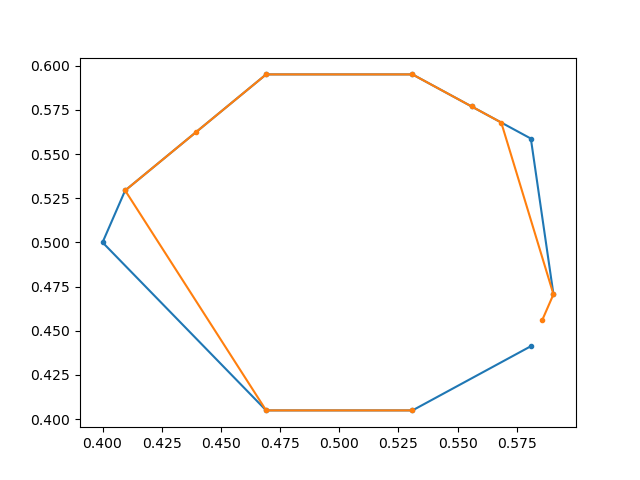

10
[[False False]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]]


In [106]:




s.split_X([0,2,5])

plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)


s.merge_X([1, 6, 9])

plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)
myx = s.X.copy()

print(s.X)
print(s.Nb)
plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()


s.adj_X([0,2,5], [1,6,9])

plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)
myx2 = s.X.copy()
print(myx2==myx)

# Time Evolution in a Stationary Fluid

Now let's iterate the fluid and boundary in time.



In [15]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 500            # simulation time 
nmod = 10               # save every nmod frames


# Immersed Body Parameters
K = 1.0
Nb = 100
rad=.1
pos=[0.5, 0.5]




#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX)                     # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)

def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS


In [16]:
####################################
  ########   Simulation   ########
####################################

fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
solids = [IB2_AMR( CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=K)]
# solids = [IB2( CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=10*K)]

#### Values that we're tracking
U = []
X = [[] for solid in solids]


dh = display('0', display_id=True)
# for i in range(nsteps+1):
for i in range(nsteps):
    iterate(fluid, solids)
    if i%nmod==0:
        
        dh.update(i)
        U.append(fluid.u.copy())
        for j, solid in enumerate(solids): X[j].append(solid.X.copy())
           

490

<IPython.core.display.Javascript object>


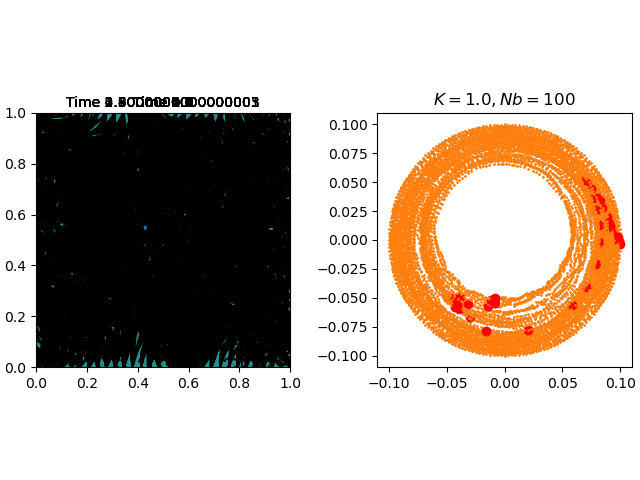

0
10
20
30
40


In [17]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb))
    axj.set_aspect('equal', 'box')
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    if i%10==0: print(i)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for j, axj in enumerate(axes_frame):
        x = X[j][i]
        im.append(ax.scatter(x[:,0]%L, x[:,1]%L, color=cmap(j)))
        im.append(ax.scatter(x[0,0]%L, x[0,1]%L, color='Red'))
        im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))

        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1), s=1))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [13]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)


In [8]:
# ani2.save('More_Boundary_Refinement.gif', writer='pillow')

In [186]:
s = solids[0]
print(s.K)
print(s.Nb)
print(s.dtheta)

100.0
100
0.06283185307179587


(100,)
(200, 2)


<IPython.core.display.Javascript object>


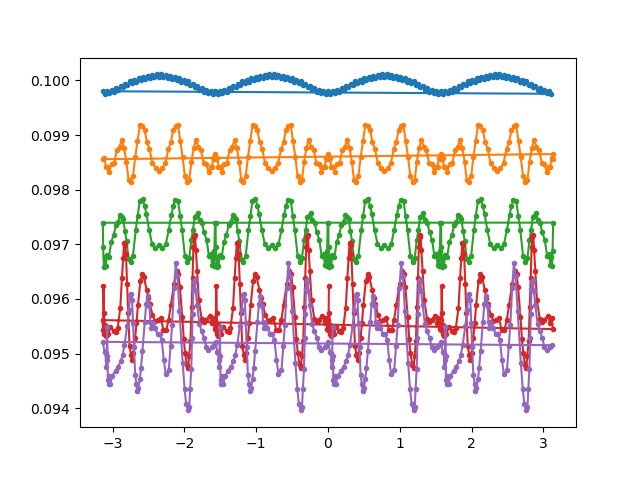

<IPython.core.display.Javascript object>


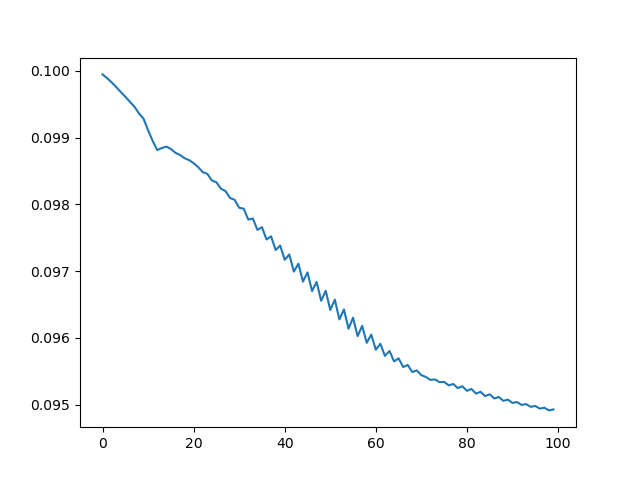

In [77]:
def get_theta(X): return np.arctan2(X[:,:,1], X[:,:,0])
def get_radii(X): return np.linalg.norm(X, axis=2)


X0 = [x - np.mean(x, axis=0)[np.newaxis, :] for x in X[0]]
print(np.shape(X0))
print(np.shape(X[0][0]))
R = [np.linalg.norm(x, axis=1) for x in X0]
th = [np.arctan2(x[:, 1], x[:, 0]) for x in X0]
plt.figure()
for i in range(0, len(R), 20): plt.plot(th[i], R[i], marker='.')
    
plt.figure()
plt.plot([np.mean(r) for r in R])

In [145]:
fig = plt.figure()
ax = fig.add_subplot()

IMS = []
for i in range(0, len(R)):  
    print(i)
    trash, trash, patches = ax.hist(th[i], color='blue',bins=np.linspace(0, np.pi, 20))
#     ims = ax.plot(i*np.arange(5))

#     ims = [ax.scatter(np.arange(5), i*np.arange(5))]
#     ims.append(ax.hist(th[i], color='blue',bins=np.linspace(0, np.pi, 20)))
#     IMS.append(ims)
    IMS.append(patches)


<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
ani2 = animation.ArtistAnimation(fig, IMS, interval=150, repeat_delay=1)


NameError: name 'animation' is not defined

# Rigid Body

In [31]:
from rpib2 import RPIB2       #### 2D penalty IB object (droplet interior)

Kp = 5000
theta = np.pi/10
rad = 0.05
Ni = 100


####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu)
fluid.dt = dt
# fluid.u[1] = 5.0
# # fluid.u[1] *= np.sin(np.linspace(0, 2*np.pi, N))[np.newaxis, :]
# fluid.u[1] *= np.linspace(0, 1, N)[np.newaxis, :]
insides = [RPIB2(SUNFLOWER(rad-fluid.h/2, positions[i], n=Ni), fluid.N, fluid.h, fluid.dt) for i in range(len(positions))]
solids = insides

#### Declare Forces
for inside in insides:
    inside.Kp = Kp    
    inside.M = M 
#     inside.bForce = lambda solid, Y: GRAV(solid, Y) - 1*solid.V + 100*TRAPPING_PLANE(Y, fluid.L)

    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
#     inside.bForce = lambda solid, Y:  0*GRAV(solid, Y, theta=theta)
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
LL = [[] for inside in insides]

U = []
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
        LL[j].append(iin.L)
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
            

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [32]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

<IPython.core.display.Javascript object>

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [33]:
ani3 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

<IPython.core.display.Javascript object>


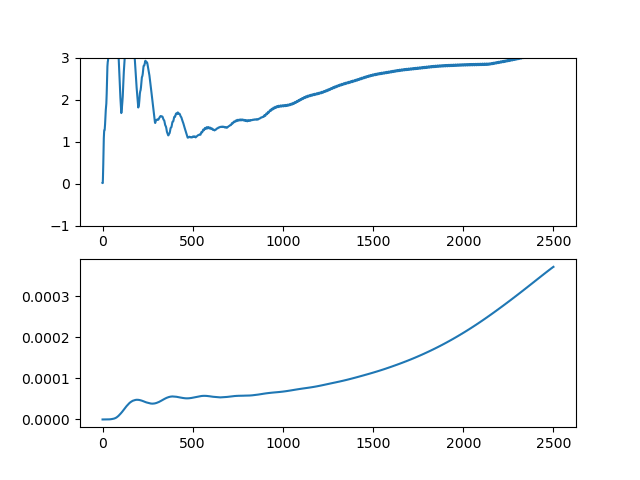

In [34]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
ax1.set_ylim([-1, 3])
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(2, 1, 2)       
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)


Rigid Body Sedimentation Plotting Functions


In [ ]:
#### Animation
%matplotlib notebook 

fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
#     im = [show_vorticity(u, L, ax)]
    im = [ax.imshow(u[1].transpose(), origin='lower', extent=[0, L, 0, L])]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [ ]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(3, 2, 1)
ax1.set_ylim([-1, 3])
ax1.set_title('Mass Marker Convergence')
ax1.set_ylabel('||X-Y||/h')
ax1.set_xlabel('Timestep')
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(3, 2, 2)       
ax2.set_title('Angular Velocity')
ax2.set_ylabel('$\omega$')
ax2.set_xlabel('Timestep')
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)
    
ax3 = fig2.add_subplot(3, 2, 3)       
ax3.set_title('$Vx_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 4)       
ax3.set_title('$Vy_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 1])
    
ax3 = fig2.add_subplot(3, 2, 5)       
ax3.set_title('$X_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 6)       
ax3.set_title('$Y_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 1])
    
fig2.tight_layout()

In [ ]:
#### Animation
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1)))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

We note that even though the force density on the fluid is the same in all three cases, the size of the arrows vary based on the local spacing of the points. In this case, boundary regions with large arrows have the same surface tension as those with small arrows, because there are fewer large arrows per unit length and vice versa.